In [3]:
#SETUP & DATA DOWNLOAD

!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/sitachhantyal/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1


In [187]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from scipy.sparse import hstack

In [154]:
#Reading files

fake_news_df=pd.read_csv(os.path.join(path, "Fake.csv"))
true_news_df=pd.read_csv(os.path.join(path, "True.csv"))

In [ ]:
# Dataset information

In [155]:
fake_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [156]:
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [157]:
true_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [158]:
true_news_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [159]:
# Add labels
true_news_df['label'] = 1  # 1 for real news
fake_news_df['label'] = 0   # 0 for fake news

In [160]:
#combining two data frames
combined_news_df= pd.concat([fake_news_df, true_news_df]).reset_index(drop=True)
combined_news_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [161]:
# Basic exploration
print(f"Dataset shape: {combined_news_df.shape}")
print("\nLabel distribution:")
print(combined_news_df['label'].value_counts())
print("\nSubject distribution:")
print(combined_news_df['subject'].value_counts())


Dataset shape: (44898, 5)

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Subject distribution:
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


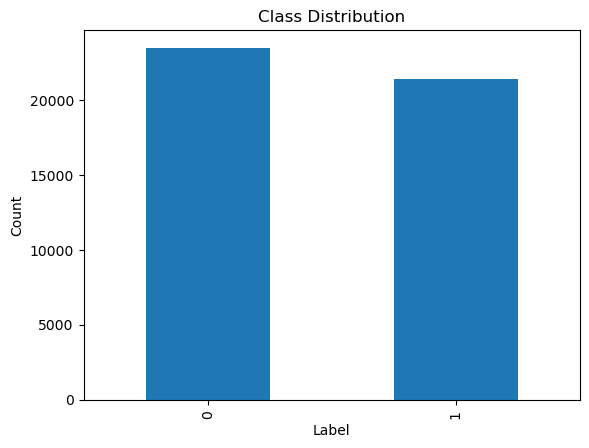

In [162]:
# Plot class distribution
plt.figure()
combined_news_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [163]:
#checking missing values
print(combined_news_df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [ ]:
# Handle duplicates

In [164]:
total_duplicates = combined_news_df.duplicated().sum()
print(f"Total duplicate rows (all columns identical): {total_duplicates}")

Total duplicate rows (all columns identical): 209


In [166]:
combined_news_df.drop_duplicates(inplace=True)

In [167]:
total_duplicates = combined_news_df.duplicated().sum()
print(f"Total duplicate rows (all columns identical): {total_duplicates}")

Total duplicate rows (all columns identical): 0


In [169]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text
# Apply text cleaning
combined_news_df["text"] = combined_news_df["text"].apply(clean_text)
combined_news_df["title"] = combined_news_df["title"].apply(clean_text)

In [171]:
# Combine title + text
combined_news_df['title_text'] = (combined_news_df['title'] + " " + combined_news_df['text'])

In [172]:
# Shuffle dataset
combined_news_df = combined_news_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Baseline Model Implementation

In [173]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(combined_news_df['title_text'],combined_news_df['label'], test_size=0.2, random_state=42)

In [174]:
# Text vectorization
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [175]:
# Predict on test data
y_pred = model.predict(X_test_vec)
# Print evaluation metrics
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4670
           1       1.00      1.00      1.00      4268

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



In [184]:
# Metrics visualization
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}


metrics_df = pd.DataFrame(metrics, index=["Score"]).T
metrics_df.reset_index(inplace=True)
metrics_df.columns = ["Metric", "Score"]


Text(0.5, 0, 'Evaluation Metric')

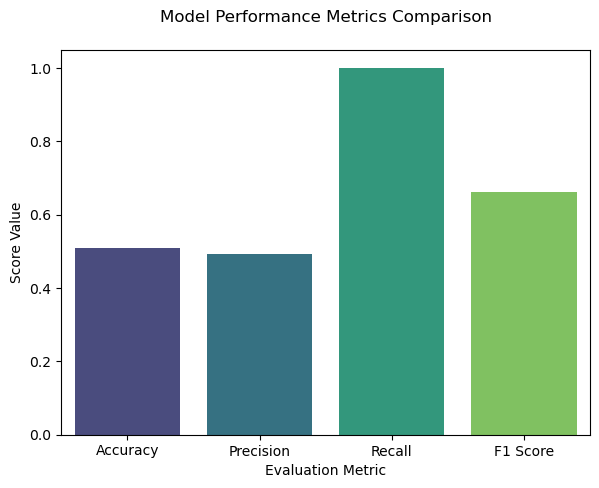

In [185]:
# Metrics plot
plt.figure(figsize=(15, 5))


plt.subplot(1, 2, 1)
ax = sns.barplot(x="Metric", y="Score", data=metrics_df, palette="viridis")
plt.title("Model Performance Metrics Comparison", pad=20)
plt.ylim(0, 1.05)
plt.ylabel("Score Value")
plt.xlabel("Evaluation Metric")

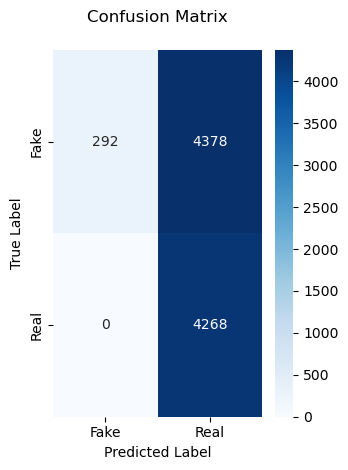

In [188]:
# Confusion matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

## Improvement 

In [177]:
#Feature Engineering
def add_text_features(df):
    df['text_len'] = df['title_text'].apply(len)
    df['word_count'] = df['title_text'].apply(lambda x: len(x.split()))
    df['uppercase_ratio'] = df['title_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))
    return df

combined_news_df = add_text_features(combined_news_df)

In [178]:
# Prepare features
X_text = combined_news_df['title_text']  # text column
X_num = combined_news_df[['text_len', 'word_count', 'uppercase_ratio']]  # numeric features
y = combined_news_df['label']
# Train-test split
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42)

In [179]:
# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_text_train_vec = vectorizer.fit_transform(X_text_train)
X_text_test_vec = vectorizer.transform(X_text_test)

In [180]:
# Combine features

X_train_final = hstack([X_text_train_vec, X_num_train])
X_test_final = hstack([X_text_test_vec, X_num_test])


In [181]:
# Model training

new_model = LinearSVC()
new_model.fit(X_train_final, y_train)

# Model evaluation

y_pred = new_model.predict(X_test_final)
print(classification_report(y_test, y_pred))

/Users/sitachhantyal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.06      0.12      4670
           1       0.49      1.00      0.66      4268

    accuracy                           0.51      8938
   macro avg       0.75      0.53      0.39      8938
weighted avg       0.76      0.51      0.38      8938



/Users/sitachhantyal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


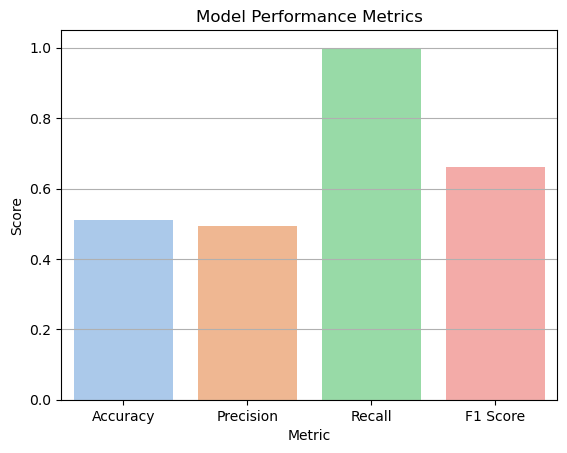

In [182]:
# Metrics visualization
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)



metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}


metrics_df = pd.DataFrame(metrics, index=["Score"]).T
metrics_df.reset_index(inplace=True)
metrics_df.columns = ["Metric", "Score"]

# Bar plot
sns.barplot(x="Metric", y="Score", data=metrics_df, palette="pastel")
plt.ylim(0, 1.05)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y')
plt.show()

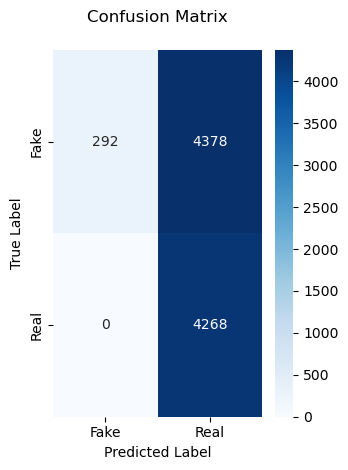

In [189]:
# Confusion matrix

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

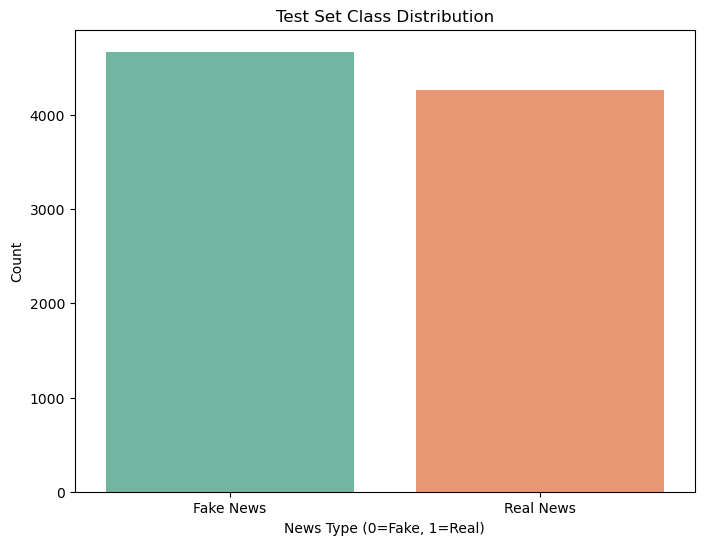

In [191]:
# Class distribution in test set

plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="Set2")
plt.title("Test Set Class Distribution")
plt.xlabel("News Type (0=Fake, 1=Real)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Fake News', 'Real News'])
plt.show()
